# Lab 4 – Canny Edge Detection (Library and Manual Implementation) 
### Aim: To perform edge detection using both OpenCV’s built-in Canny method and a manual implementation of the algorithm. 
### Objectives: 
- **Use OpenCV’s cv2.Canny() for automatic edge detection.**
- **Implement each stage of the Canny algorithm manually Gaussian smoothing, gradient computation, Non-Maximum Suppression, and hysteresis thresholding.**
- **Compare library and manual outputs for edge quality and performance.** 
- **Understand how thresholding impacts edge connectivity and clarity.**

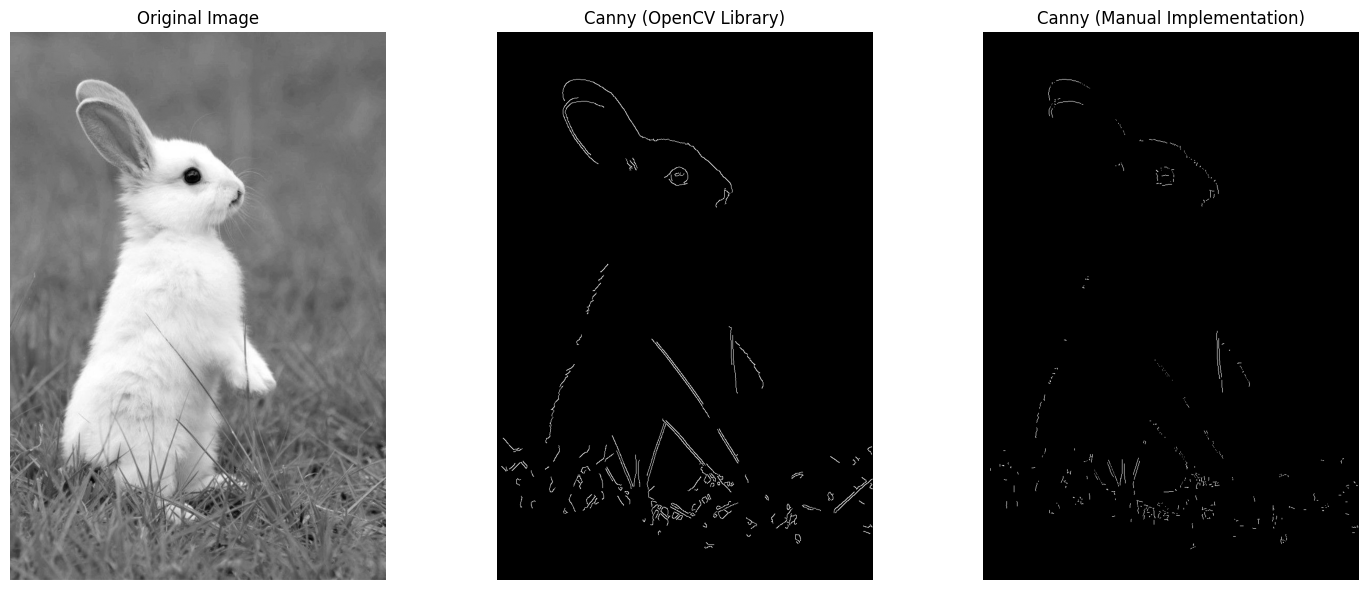

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the image in grayscale
img = cv2.imread(r"C:\Users\SHRAVINYA\Downloads\lab4.jpg", cv2.IMREAD_GRAYSCALE)

# Step 2: Apply Gaussian Blur to reduce noise (library version)
blurred = cv2.GaussianBlur(img, (5, 5), 1.4)

# Step 3: Built-in OpenCV Canny Edge Detection
edges_lib = cv2.Canny(blurred, 100, 200)

# -------------------- Manual Canny Implementation -------------------

# Step 4: Manual Gaussian smoothing
def gaussian_blur_manual(image, kernel_size=5, sigma=1.4):
    k = cv2.getGaussianKernel(kernel_size, sigma)
    gaussian_kernel = np.outer(k, k)
    return cv2.filter2D(image, -1, gaussian_kernel)

smoothed = gaussian_blur_manual(img)

# Step 5: Compute intensity gradients using Sobel filters
Gx = cv2.Sobel(smoothed, cv2.CV_64F, 1, 0, ksize=3)
Gy = cv2.Sobel(smoothed, cv2.CV_64F, 0, 1, ksize=3)
magnitude = np.sqrt(Gx**2 + Gy**2)
angle = np.arctan2(Gy, Gx)

# Step 6: Non-Maximum Suppression (NMS)
def non_max_suppression(grad_mag, grad_dir):
    M, N = grad_mag.shape
    Z = np.zeros((M, N), dtype=np.uint8)
    angle = grad_dir * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, M - 1):
        for j in range(1, N - 1):
            q = 255
            r = 255

            # angle 0
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                q = grad_mag[i, j + 1]
                r = grad_mag[i, j - 1]
            # angle 45
            elif (22.5 <= angle[i, j] < 67.5):
                q = grad_mag[i + 1, j - 1]
                r = grad_mag[i - 1, j + 1]
            # angle 90
            elif (67.5 <= angle[i, j] < 112.5):
                q = grad_mag[i + 1, j]
                r = grad_mag[i - 1, j]
            # angle 135
            elif (112.5 <= angle[i, j] < 157.5):
                q = grad_mag[i - 1, j - 1]
                r = grad_mag[i + 1, j + 1]

            if (grad_mag[i, j] >= q) and (grad_mag[i, j] >= r):
                Z[i, j] = grad_mag[i, j]
            else:
                Z[i, j] = 0
    return Z

nms = non_max_suppression(magnitude, angle)

# Step 7: Hysteresis Thresholding
def hysteresis_threshold(img, low, high):
    M, N = img.shape
    res = np.zeros((M, N), dtype=np.uint8)
    strong = 255
    weak = 75

    strong_i, strong_j = np.where(img >= high)
    weak_i, weak_j = np.where((img <= high) & (img >= low))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    # Edge tracking by hysteresis
    for i in range(1, M - 1):
        for j in range(1, N - 1):
            if res[i, j] == weak:
                if (
                    (res[i + 1, j - 1] == strong)
                    or (res[i + 1, j] == strong)
                    or (res[i + 1, j + 1] == strong)
                    or (res[i, j - 1] == strong)
                    or (res[i, j + 1] == strong)
                    or (res[i - 1, j - 1] == strong)
                    or (res[i - 1, j] == strong)
                    or (res[i - 1, j + 1] == strong)
                ):
                    res[i, j] = strong
                else:
                    res[i, j] = 0
    return res

edges_manual = hysteresis_threshold(nms, low=50, high=150)

# -------------------- Visualization -------------------
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edges_lib, cmap='gray')
plt.title("Canny (OpenCV Library)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(edges_manual, cmap='gray')
plt.title("Canny (Manual Implementation)")
plt.axis('off')

plt.tight_layout()
plt.show()
